In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
#Drawing decision trees
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.core.display import HTML 

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)


In [3]:
train_df = pd.read_csv('data/flight_delays_train.csv.zip')
test_df = pd.read_csv('data/flight_delays_test.csv.zip')

In [4]:
train_df.shape, test_df.shape

((100000, 9), (100000, 8))

In [5]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')

In [6]:
train_df.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [8]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [9]:
train_df['dep_delayed_15min'].value_counts(normalize = True)

N    0.80956
Y    0.19044
Name: dep_delayed_15min, dtype: float64

### Data preprocessing

In [10]:
X = train_df.drop(columns = ['dep_delayed_15min'])
y = train_df['dep_delayed_15min']

In [11]:
#Stage 1

X['Month_1'] = np.array([value[2:] for value in X['Month'].values]).astype('object')
X['DayOfMonth_1'] = np.array([value[2:] for value in X['DayofMonth'].values]).astype('object')
X['DayOfWeek_1'] = np.array([value[2:] for value in X['DayOfWeek'].values]).astype('object')

In [12]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6


In [13]:
#Stage 2

le = LabelEncoder()
columns_le = ['UniqueCarrier', 'Origin', 'Dest']

for column in columns_le:
    le.fit(X[column])
    X[column+str('_1')] = le.transform(X[column]).astype('object')

In [14]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7,0,18,78
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3,18,217,171
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5,20,228,59
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6,15,78,175
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6,19,174,199


In [15]:
#Stage 3 
X['DepTime_1'] = X['DepTime'].astype('float64')
X['Distance_1'] = X['Distance'].astype('float64')

In [16]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7,0,18,78,1934.0,732.0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3,18,217,171,1548.0,834.0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5,20,228,59,1422.0,416.0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6,15,78,175,1015.0,872.0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6,19,174,199,1828.0,423.0


In [17]:
#Stage 4 delete repeating columns
cols_del = train_df.columns.drop('dep_delayed_15min')

In [18]:
X.drop(columns = cols_del, inplace = True)

In [19]:
X.head()

,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
0,8,21,7,0,18,78,1934.0,732.0
1,4,20,3,18,217,171,1548.0,834.0
2,9,2,5,20,228,59,1422.0,416.0
3,11,25,6,15,78,175,1015.0,872.0
4,10,7,6,19,174,199,1828.0,423.0


In [20]:
#Stage 5: Map target columns to {0,1}
mapping = {'N': 0, 'Y': 1}
y = train_df['dep_delayed_15min'].map(mapping)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17, shuffle = True)

In [22]:
X_train.head()

,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
98187,4,18,1,13,20,175,1148.0,559.0
25139,8,13,7,12,228,35,645.0,612.0
83491,4,5,3,10,124,159,525.0,102.0
8295,12,31,7,6,204,252,1336.0,1249.0
65284,8,9,2,0,79,234,1653.0,1171.0


In [23]:
X_valid.head()

,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
53844,10,20,4,18,208,210,702.0,951.0
10034,6,14,2,0,132,78,707.0,224.0
2592,8,2,2,19,198,152,1600.0,337.0
19398,12,21,4,17,204,130,2132.0,589.0
26446,5,9,2,21,204,21,1320.0,631.0


# Decision Trees

In [24]:
dt = DecisionTreeClassifier(random_state = 17)

In [25]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [26]:
dt_preds = dt.predict(X_valid)
dt_acc_score = accuracy_score(dt_preds, y_valid)
dt_roc_auc_score = roc_auc_score(dt_preds, y_valid)

In [27]:
print(f'Accuracy score using DecisionTreeClassifier: {dt_acc_score}')
print(f'ROC-AUC score using DecisionTreeClassifier: {dt_roc_auc_score}')

Accuracy score using DecisionTreeClassifier: 0.7279
ROC-AUC score using DecisionTreeClassifier: 0.5685855927057489


Bear in mind that we are using each feature in this out-of-the-box DecisionTree. Second, the data is relatively speaking imbalanced, so using StratifiedKFoldCV is **a must.** Let's compare it to the **predict all that are non delayed** model.

In [28]:
train_df['dep_delayed_15min'].value_counts(normalize = True)

N    0.80956
Y    0.19044
Name: dep_delayed_15min, dtype: float64

The share of non-delayed airplaines in the sample is around 80%. The most naive model that always predicts a "loyal customer" on such data will guess right in about 80% of all cases. That is, the proportion of correct answers (accuracy) of subsequent models should be no less than this number, and will hopefully be significantly higher.

### DecisionTree (GridSearchCV)

In [29]:
tree_params = {'max_depth': range(2, 11), 
               'min_samples_leaf' : range(2,11),
               } #'max_features': range(2, len(X.columns)+1) could be used here

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)

In [30]:
tree_grid = GridSearchCV(estimator = dt, param_grid = tree_params, cv = skf, n_jobs = -1)

In [31]:
%%time
tree_grid.fit(X_train, y_train)

CPU times: user 13.3 s, sys: 1.6 s, total: 14.9 s
Wall time: 18.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [32]:
tree_grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 8}

In [33]:
tree_grid.best_score_

0.8134142857142856

So, we see that our accuracy score improved by using better validation scheme, and by tuning our trees. Maybe if we tuned it a little more (max_features etc.) we would obtain better results. Let's see what features seem important according to best decision tree model. 

In [34]:
#tree_graph_to_png(tree_grid.best_estimator_, X.columns, png_file_to_save='decision_tree.png')

In [35]:
tree_grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [36]:
best_tree = tree_grid.best_estimator_ #Will save this one for later, just in case. 

In [37]:
tree_features = pd.DataFrame(data = tree_grid.best_estimator_.feature_importances_,
                             index = X.columns,
                             columns = ['Importance'])

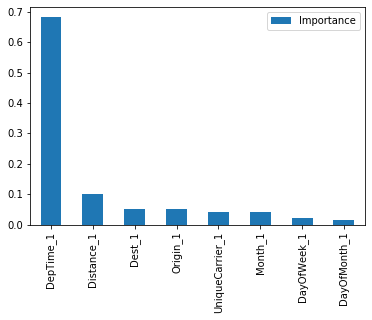

In [38]:
tree_features.sort_values(by = 'Importance', ascending = False).plot(kind = 'bar');

The model is stable if the standard deviation on validation for model with best parameters is less than 0.5%.

In [39]:
is_best_score = tree_grid.cv_results_['rank_test_score'] == 1 
best_score_test_std = tree_grid.cv_results_['std_test_score'][is_best_score][0]*100

In [40]:
best_score_test_std < 0.5

True

This means that CV test scores are distributed with very narrow normal distribution, and hence it is relatively precise measure of expectation on test-set. But accuracy is not a good metric for imbalanced dataset, and hence we will move to ROC-AUC. 

### Decision Tree (GridSearchCV - ROC/AUC)

In [41]:
tree_grid_auc = GridSearchCV(estimator = dt, scoring = 'roc_auc',
                             param_grid = tree_params, cv = skf, n_jobs = -1)

In [42]:
%%time
tree_grid_auc.fit(X_train, y_train)

CPU times: user 9.39 s, sys: 1.32 s, total: 10.7 s
Wall time: 14.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [43]:
print(f'Best parameters based on CV: {tree_grid_auc.best_params_}')

Best parameters based on CV: {'max_depth': 6, 'min_samples_leaf': 2}


In [44]:
print(f'Best ROC/AUC score for the DecisionTreeClassifier is: {tree_grid_auc.best_score_}')

Best ROC/AUC score for the DecisionTreeClassifier is: 0.6965646826948759


In [45]:
dt_auc_pred = tree_grid.best_estimator_.predict(X_valid)

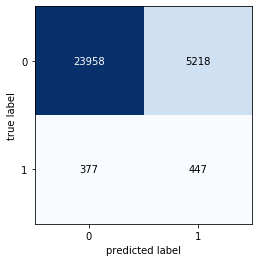

In [46]:
plot_confusion_matrix(confusion_matrix(dt_auc_pred, y_valid));

Tuning in how much FP's, TP's, TN's and FN's we want to tolerate depends on the bussines task/problem at hand. For example, to totally reduce the risk of an outbreak of some disease (ebola etc.) we have to sacriface something and correctly classify 'every' sample that is infected with ebola. When I say 'sacrifice something' it means that all of the metrics depend directly by dialing-and-knobing TPs, TNs etc. where in a sense we can 'fight' some cases in favour of other, that is, make a 'trade-off'. 

There is a ton of variations to tackle this Kaggle problem since the only idea is to improve ROC-AUC score. They don't care how, and intuitevly by improving AUC score we improve our classifier in a sense that it is good at separating two classes.

ROC curves are usually represented as False Positive Rate (x-axis) vs True Positive Rate (y-axis). 
By default treshold probability 'is in class' is == 0.5, and that can vary from 0 to 1 and hence directly changing specificity and sensitivity.

AUC, as I said, in some sense tells us how good is our classifier at separating two classes, and we see that by using all our features. If AUC == 0.5 then it means that our classifier is too bad at distinguishing (aka separating) our two classes and, since it means that two distributions are overlaping 100%, one can think of AUC == 0.5 intuitevly as 'all we can do is to just random guess which class does it belong since those are completely mixed up'. Of course, provided that both classes are normaly distributed and have the same mean and standard deviation. 

Since I don't use these very often, here they will be just for reference: 

Sensitivity/Recall (True Positive Rate) = True positives (TPs)/ (True Positives (TPs) + False Negatives(FNs))

Specificity (False Positive Rate) = 1 - Sensitivity = False Positives (FPs) / (False Positives (FPs) + True Negatives (TNs) 

Precision  = True Positives (TPs) / Predicted YES

Again, let's plot our confusion matrix, get some sense how good is our classifier and propose a strategy for dealing with it. 

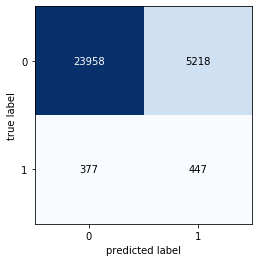

In [47]:
plot_confusion_matrix(confusion_matrix(dt_auc_pred, y_valid));

In [48]:
X_valid.shape[0], y_valid.value_counts()

(30000,
 0    24335
 1     5665
 Name: dep_delayed_15min, dtype: int64)

One can see that out of all 30000 samples in our validation set where 24335 belong to 0 ('not-delayed') and 5665 belong to 1 ('delayed') our classifier is relatively good at predicting labels 0 (True Negatives). On the contrary, there are way too many False Negatives (5218 of them), and hence our model is very bad at predicting True Positives (447 out of 5665).

This is why in imbalanced datasets accuracy is no way of measuring a succes even if other metrics could be written in terms of it! Again, I have to mention that so far we haven't done any feature engineering which might help us to improve these 'out of box' models, that is help a model to have a 'cleaner separation' in classes.

Let's just imagine a buisness case scenario where we have to predict those delayed flights. For a simplicity of things let's just say that those cost us so much money even if there are majority of flights that aren't delayed. In this case we have to improve True Positives in order to detect them better. The byproduct of that is that we will (hopefully!) also improve our ROC-AUC score.

# Logistic Regression

**Strategy #1** 
We will start off by training plain LogisticRegression without hyperparameter tuning, and by using it's own way of dealing with imbalanced data: parameter class_weight which in an essence puts weights on errors proportional to the class imbalance. Specifically, the balanced argument will automatically weigh classes inversely proportional to their frequency. 

Just a quick thoughts on hyperparameter tuning. So far I've observed that LogisticRegression algos are not too sensitive to hyperparameter tuning. For my 'plain' LogisticRegression I will use 'lbfgs' solver since it is considered fastest and handles both L1 and L2 regularization, and max_iters will be set to 500 because if we use default version which equals 100 there might be a convergence problem. 

It is convenient to use feature scaling when we are dealing with any type of linear classifiers which in essence are learning weights associated with each feature. We don't want to overemphasise some features over the others, that is we want to put them on the same scale and hence we use StandardScaler (z-score). Another consequences of feature scaling is that it makes our 'loss function' more properly scaled which implies faster convergence towards (possibly) global minimum, and it is a must to have our feature importance validly interpreted. 

In [49]:
logit = LogisticRegression(random_state = 17, solver = 'lbfgs', C = 1,
                           class_weight = 'balanced', max_iter = 500)
logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])

In [50]:
%%time
logit_pipe.fit(X_train, y_train)

CPU times: user 219 ms, sys: 8.81 ms, total: 227 ms
Wall time: 133 ms


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logit',
                 LogisticRegression(C=1, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=17,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [51]:
logit_val_preds = logit_pipe.predict(X_valid)
logit_acc_score = accuracy_score(logit_val_preds, y_valid)
logit_roc_auc_score = roc_auc_score(logit_val_preds, y_valid)

In [52]:
print(f'Accuracy score using LogisticRegression: {logit_acc_score}')
print(f'ROC-AUC score using LogisticRegression: {logit_roc_auc_score}')

Accuracy score using LogisticRegression: 0.6199333333333333
ROC-AUC score using LogisticRegression: 0.5804741675968011


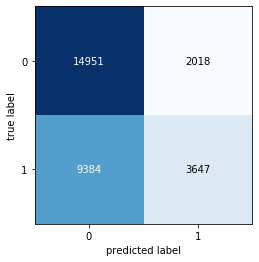

In [53]:
#LogisticRegressionClassifier confusion matrix
plot_confusion_matrix(confusion_matrix(logit_val_preds, y_valid));

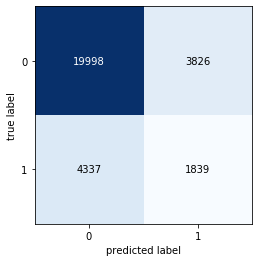

In [54]:
#DecisionTreeClassifier confusion matrix
plot_confusion_matrix(confusion_matrix(dt_preds, y_valid));

In [55]:
print(f'ROC-AUC score for DecisionTreeClassifier is {dt_roc_auc_score}, and for LogisticRegression {logit_roc_auc_score}.')

ROC-AUC score for DecisionTreeClassifier is 0.5685855927057489, and for LogisticRegression 0.5804741675968011.


Since accuracy score on DecisionTree without hyperparameter tuning is higher (0.7279) than the one using baseline LogisticRegression (around 0.6199) it could mean that Decision Tree based algorithms would work better here, but we will check it just to be thorough. 

On the contrary, plain LogisticRegressionClassifier has better ROC-AUC score then plain DecisionTree and based on comparing confusion matrices, we see that class_weight = balanced might actually do a good job here in terms of predicting TruePositives here! Maybe if one could tune those using GridSearchCV we would get even better results! 

### LogisticRegression (GridSearchCV - ROC-AUC/F1 score)

**Strategy #2** 
We have already seen that accuracy is not a good metric for imbalaced dataset, that is, it gives a false impression that we are doing 'good'.

Since I wanted to tackle improving ROC-AUC score (that is the Kaggle metric to improve upon in a first place) in order to make this more interesting I will also think of this as solving our ficticious business case I've mentioned earlier and try to improve ROC-AUC score by improving F1 score.

The F1 score is a metric that attempts to take that tradeoff between false positives, false negatives and  detected delayed flights, since it is calculted as harmonic mean between Precision and Recall. 

Another thing I want to tune is L2 regularization coefficient which in an essence tackles overfitting problem by making weights more constrained.

In [64]:
weights = np.linspace(0.05, 0.95, 20)
param_grid = {'logit__C': np.logspace(-3, 1, 10),
              'logit__class_weight': [{0: x, 1: 1.0-x} for x in weights]}
logit_grid = GridSearchCV(estimator = logit_pipe, scoring = 'f1', 
                          param_grid = param_grid, cv = skf, n_jobs = -1)

In [65]:
%%time
logit_grid.fit(X_train, y_train)

CPU times: user 34 s, sys: 5.2 s, total: 39.2 s
Wall time: 45.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logit',
                                        LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=500,
                

In [66]:
logit_grid.best_score_, logit_grid.best_params_

(0.39545436929188504,
 {'logit__C': 1.2915496650148828,
  'logit__class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}})

In [69]:
logit_grid_preds = logit_grid.predict(X_valid)
accuracy_score(logit_grid_preds, y_valid), roc_auc_score(logit_grid_preds, y_valid)

(0.6216333333333334, 0.5805736071553034)